In [1]:
Times = 100
N = 10
Max = 10
K_paths = 10
Pc = 0.8
Pm = 0.8
Ts = 2
p = 0.2
a = 0.1
b = 0.5
p0 = 0.1
Q = 1

In [2]:
from YenAlgorithm import YenAlgorithm
weight_map={}
temp = 0
with open('metric_data_20_new.txt') as f:
    for line in f:
        strt = line
        strt2 = strt.split(':')
        my_result = list(map(int, strt2[0].split(',')))
        if (temp!=my_result[0]):
            weight_map[my_result[0]]={}
        weight_map[my_result[0]][my_result[1]] = int(strt2[1])
        temp = my_result[0]
vertices = [i for i in range(1,21)]
alg_y = YenAlgorithm(weight_map,vertices,2,7,K_paths)
paths_vertices = alg_y.compute_shortest_paths()

In [3]:
paths_length = []
for path in paths_vertices:
    s = 0
    for i in range(len(path)-1):
        s+= weight_map[path[i]][path[i+1]]
    paths_length.append(s)
print(paths_length)
CD = sum(paths_length)
paths_vertices

[160, 170, 175, 175, 180, 190, 195, 200, 205, 210]


[[2, 15, 18, 19, 5, 7],
 [2, 15, 18, 19, 20, 7],
 [2, 9, 10, 6, 14, 7],
 [2, 15, 18, 19, 5, 20, 7],
 [2, 16, 17, 19, 5, 7],
 [2, 16, 17, 19, 20, 7],
 [2, 16, 17, 19, 5, 20, 7],
 [2, 15, 18, 5, 7],
 [2, 9, 10, 12, 13, 7],
 [2, 15, 18, 4, 14, 7]]

In [4]:
CD

1860

In [5]:
import numpy as np
import random
import math
import copy
from YenAlgorithm import YenAlgorithm

class Ant(object):
    def __init__(self):
        self.path = []
        self.fitness = float('inf')
        self.delta = 0


class AS:

    def __init__(self, src, dst, N, Max, K_paths, p, a, b, p0, Q):
        self.switches = [i for i in range(1,21)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.K_paths = K_paths
        self.p = p
        self.a = a
        self.b = b
        self.p0 = p0
        self.Q = Q
        self.colony = [Ant() for i in range(self.N)]
        self.condidates = []
        self.best = []
        self.pheromone = self.CreatePheromone()
        self.CD = 0
    
    def CreatePheromone(self):
        pheromone = copy.deepcopy(self.adjacency)
        for sw_1 in self.adjacency.keys():
            for sw_2 in self.adjacency[sw_1].keys():
                pheromone[sw_1][sw_2] = 1/self.weight_map[sw_1][sw_2]
        return pheromone
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('metric_data_20_new.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreatePath(self):
        for i in range(self.N):
            path = []
            current_switch = self.src
            path.append(current_switch)
            while(current_switch!=self.dst):
                neighbor_switches = set(self.adjacency[current_switch].keys())-set(path)
                neighbor_switches = list(neighbor_switches)
                if(len(neighbor_switches)==0):
                    path.clear()
                    current_switch = self.src
                    path.append(current_switch)
                else:
                    current_switch = self.GetNextSwitch(neighbor_switches, current_switch)
                    path.append(current_switch)
            self.colony[i].path = copy.deepcopy(path)
            self.colony[i].fitness = self.Evaluate(self.colony[i].path)
            self.colony[i].delta = self.Q/self.colony[i].fitness

    def GetNextSwitch(self, neighbor_switches, current_switch):
        summ = 0
        for sw in neighbor_switches:
            x = self.pheromone[current_switch][sw]
            y = 1/(self.weight_map[current_switch][sw])
            z = pow(x,self.a)*pow(y,self.b)
            summ+=z
        prob = []
        for sw in neighbor_switches:
            x = self.pheromone[current_switch][sw]
            y = 1/(self.weight_map[current_switch][sw])
            z = pow(x,self.a)*pow(y,self.b)
            prob.append(z/summ)
        p = np.random.rand()
        next_switch = np.random.choice(neighbor_switches,p=prob)
        return next_switch

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def UpdatePheromone(self):
        for sw_1 in self.pheromone.keys():
            for sw_2 in self.pheromone[sw_1].keys():
                self.pheromone[sw_1][sw_2]=self.pheromone[sw_1][sw_2]*(1-self.p)
        for i in range(self.N):
            for j in range(len(self.colony[i].path) - 1):
                p1 = self.colony[i].path[j]
                p2 = self.colony[i].path[j + 1]
                self.pheromone[p1][p2] += self.colony[i].delta
                self.pheromone[p2][p1] += self.colony[i].delta
     
    def MemorizeCondidates(self):
        self.colony.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.colony)):
            dk_3 = False
            for ant in condidate:
                if(tuple(ant.path)==tuple(self.colony[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.colony[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))

    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        self.CD = 0
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for ant in self.best:
                if(tuple(ant.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break
        for ant in self.best:
            self.CD += ant.fitness
                
    def Do(self):
        while(self.CD!=CD):
            self.CreatePath()
            self.UpdatePheromone()
            self.MemorizeCondidates()
            self.GetBest()

In [6]:
import numpy as np
import random
import math
import copy
from YenAlgorithm import YenAlgorithm

class Ant(object):
    def __init__(self):
        self.path = []
        self.fitness = float('inf')
        self.delta = 0


class ACS:

    def __init__(self, src, dst, N, Max, K_paths, p, a, b, p0, Q):
        self.switches = [i for i in range(1,21)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.K_paths = K_paths
        self.p = p
        self.a = a
        self.b = b
        self.p0 = p0
        self.Q = Q
        self.colony = [Ant() for i in range(self.N)]
        self.condidates = []
        self.best = []
        self.pheromone = self.CreatePheromone()
        self.CD = 0
    
    def CreatePheromone(self):
        pheromone = copy.deepcopy(self.adjacency)
        for sw_1 in self.adjacency.keys():
            for sw_2 in self.adjacency[sw_1].keys():
                pheromone[sw_1][sw_2] = 1/self.weight_map[sw_1][sw_2]
        return pheromone
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('metric_data_20_new.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreatePath(self):
        for i in range(self.N):
            path = []
            current_switch = self.src
            path.append(current_switch)
            while(current_switch!=self.dst):
                neighbor_switches = set(self.adjacency[current_switch].keys())-set(path)
                neighbor_switches = list(neighbor_switches)
                if(len(neighbor_switches)==0):
                    path.clear()
                    current_switch = self.src
                    path.append(current_switch)
                else:
                    current_switch = self.GetNextSwitch(neighbor_switches, current_switch)
                    path.append(current_switch)
            self.colony[i].path = copy.deepcopy(path)
            self.colony[i].fitness = self.Evaluate(self.colony[i].path)
            self.colony[i].delta = self.Q/self.colony[i].fitness

    def GetNextSwitch(self, neighbor_switches, current_switch):
        summ = 0
        for sw in neighbor_switches:
            x = self.pheromone[current_switch][sw]
            y = 1/(self.weight_map[current_switch][sw])
            z = pow(x,self.a)*pow(y,self.b)
            summ+=z
        prob = []
        prob_2 = []
        sw_max = 1
        z_max = 0
        for sw in neighbor_switches:
            x = self.pheromone[current_switch][sw]
            y = 1/(self.weight_map[current_switch][sw])
            z = pow(x,self.a)*pow(y,self.b)
            prob.append(z/summ)
            z2 = x*pow(y,self.b)
            if(z2>z_max):
                z_max = z2
                sw_max = sw
        p = np.random.rand()
        if(p <= self.p0):
            next_switch= sw_max
        else:
            sw = np.random.choice(neighbor_switches,p=prob)
            next_switch= sw
            # update local
            self.pheromone[current_switch][next_switch]=self.pheromone[current_switch][next_switch]*(1-self.p)
            self.pheromone[next_switch][current_switch]=self.pheromone[next_switch][current_switch]*(1-self.p)
        return next_switch

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def UpdatePheromone(self):
        # update global
        self.colony.sort(key=lambda x: x.fitness)
        for j in range(len(self.colony[0].path) - 1):
            p1 = self.colony[0].path[j]
            p2 = self.colony[0].path[j + 1]
            self.pheromone[p1][p2] = (1-self.p)*self.pheromone[p1][p2] + self.p*self.colony[0].delta
            self.pheromone[p2][p1] = (1-self.p)*self.pheromone[p2][p1] + self.p*self.colony[0].delta
     
    def MemorizeCondidates(self):
#         self.colony.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.colony)):
            dk_3 = False
            for ant in condidate:
                if(tuple(ant.path)==tuple(self.colony[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.colony[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))

    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        self.CD = 0
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for ant in self.best:
                if(tuple(ant.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break
        for ant in self.best:
            self.CD += ant.fitness
                
    def Do(self):
        while(self.CD!=CD):
            self.CreatePath()
            self.UpdatePheromone()
            self.MemorizeCondidates()
            self.GetBest()

In [7]:
import numpy as np
import random
import math
import copy
from YenAlgorithm import YenAlgorithm

class Genome(object):
    def __init__(self):
        self.path = []
        self.fitness = float('inf')

class GA:

    def __init__(self, src, dst, N, Max, K_paths, Pc, Pm, Ts):
        self.switches = [i for i in range(1,21)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.Pm = Pm
        self.Pc = Pc
        self.K_paths = K_paths
        self.population = [self.CreateGenome() for i in range(self.N)]
        self.condidates = []
        self.best = []
        self.Ts = Ts
        self.CD = 0
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('metric_data_20_new.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreateGenome(self):
        newGenome = Genome()
        newGenome.path.append(self.src)
        current_switch = self.src
        while(current_switch!=self.dst):
            neighbor_switches = set(self.adjacency[current_switch].keys())-set(newGenome.path)
            neighbor_switches = list(neighbor_switches)
            if(len(neighbor_switches)==0):
                newGenome.path.clear()
                current_switch = self.src
                newGenome.path.append(self.src)
            else:
                next_switch = random.choice(neighbor_switches)
                newGenome.path.append(next_switch)
                current_switch = next_switch
        newGenome.fitness = self.Evaluate(newGenome.path)
        return newGenome

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def CorrectGenome(self,genome):
        dk = False
        for i in range(1,len(genome.path)-2):
            for j in range(i+1,len(genome.path)-1):
                if(genome.path[i]==genome.path[j]):
                    del genome.path[i+1:j+1]
                    dk = True
                    break
            if(dk==True):
                break
        return genome
    
    def ExchangeGenes(self, parents_1, parents_2):
        dk = False
        for i in range(1,len(parents_1.path)-1):
            for j in range(1,len(parents_2.path)-1):
                if(parents_1.path[i]==parents_2.path[j]):
                    tail_1 = copy.deepcopy(parents_1.path[i+1:])
                    tail_2 = copy.deepcopy(parents_2.path[j+1:])
                    del parents_1.path[i+1:]
                    del parents_2.path[j+1:]
                    parents_1.path.extend(tail_2)
                    parents_2.path.extend(tail_1)
                    dk = True
                    break
            if(dk==True):
                break
        return parents_1, parents_2
    
    def Crossover(self):
        children = []
        for i in range(0,self.N,2):
            father = random.randint(0,self.N-1)
            mother = random.randint(0,self.N-1)
            parents_1 = copy.deepcopy(self.population[father])
            parents_2 = copy.deepcopy(self.population[mother])
            if random.uniform(0,1) < self.Pc:
                child_1, child_2 = self.ExchangeGenes(parents_1, parents_2)
                child_1 = self.CorrectGenome(child_1)
                child_2  = self.CorrectGenome(child_2 )
                child_1.fitness = self.Evaluate(child_1.path)
                child_2.fitness = self.Evaluate(child_2.path)
                children.append(copy.deepcopy(child_1))
                children.append(copy.deepcopy(child_2))
            else:
                children.append(copy.deepcopy(parents_1))
                children.append(copy.deepcopy(parents_2))
        self.population = copy.deepcopy(children)
    
    def Mutation(self):
        for i in range(len(self.population)):
            if random.uniform(0,1) < self.Pm:
                parents = copy.deepcopy(self.population[i]) 
                ls = list(range(1,len(parents.path)-1))
                point_mutation = random.choice(ls)
                current_switch = parents.path[point_mutation]
                del parents.path[point_mutation+1:]
                save_parents = copy.deepcopy(parents.path)
                while(current_switch!=self.dst):
                    neighbor_switches = set(self.adjacency[current_switch].keys())-set(parents.path)
                    neighbor_switches = list(neighbor_switches)
                    if(len(neighbor_switches)==0):
                        parents.path = copy.deepcopy(save_parents)
                        current_switch = parents.path[point_mutation]
                    else:
                        next_switch = random.choice(neighbor_switches)
                        parents.path.append(next_switch)
                        current_switch = next_switch
                parents.fitness = self.Evaluate(parents.path)
                self.population[i] = copy.deepcopy(parents)
                
    def Selection(self):
        selected_population=[]
        for i in range(self.N):
            selected_index = np.random.randint(0,len(self.population)-1)
            for ix in np.random.randint(0,len(self.population)-1,self.Ts-1):
                if(self.population[ix].fitness<self.population[selected_index].fitness):
                    selected_index = ix
            selected_population.append(self.population[selected_index])
        self.population = copy.deepcopy(selected_population)
    
    def MemorizeCondidates(self):
        self.population.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.population)):
            dk_3 = False
            for genome in condidate:
                if(tuple(genome.path)==tuple(self.population[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.population[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))
    
    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        self.CD = 0
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for genome in self.best:
                if(tuple(genome.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break
        for genome in self.best:
            self.CD += genome.fitness
    
    def Do(self):
        while(self.CD!=CD):
            self.Crossover()
            self.Mutation()
            self.Selection()
            self.MemorizeCondidates()
            self.GetBest()

In [8]:
import time
time_1 = []
time_2 = []
time_3 = []
for i in range(Times):
    alg_1 = AS(2,7,N, Max, K_paths, p, a, b, p0, Q)
    start_1 = time.time()
    alg_1.Do()
    end_1 = time.time()
    time_1.append(end_1 - start_1)
    
    alg_2 = ACS(2,7,N, Max, K_paths, p, a, b, p0, Q)
    start_2 = time.time()
    alg_2.Do()
    end_2 = time.time()
    time_2.append(end_2 - start_2)
            
#     alg_3 = GA(2,7,N, Max, K_paths, Pc, Pm, Ts)
#     start_3 = time.time()
#     alg_3.Do()
#     end_3 = time.time()
#     time_3.append(end_3 - start_3)

KeyboardInterrupt: 

In [9]:
print(time_1)
print(time_2)
print(time_3)

[0.5223956108093262, 0.6596114635467529, 0.8492810726165771, 0.5194966793060303, 0.24031662940979004, 0.7337446212768555, 0.29471468925476074, 0.885045051574707, 0.21042299270629883, 0.3449108600616455, 0.33808422088623047, 0.4587438106536865, 3.0099284648895264]
[0.2559993267059326, 0.3209652900695801, 0.39496350288391113, 0.3602263927459717, 0.4086308479309082, 0.5003960132598877, 0.3177344799041748, 0.08800625801086426, 0.1812894344329834, 0.3921072483062744, 0.26028966903686523, 0.2555124759674072]
[]


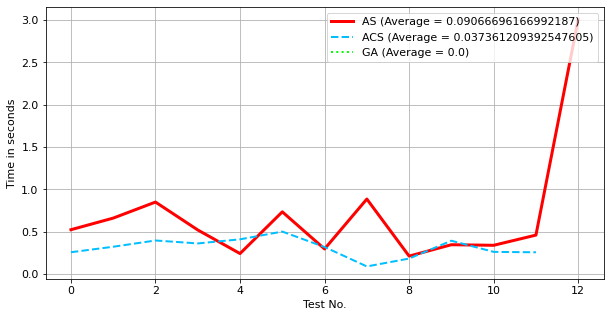

In [10]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
font = {'size'   : 11}
matplotlib.rc('font', **font)
figg1 = plt.figure(figsize=(10,5))
avr_1 = (sum(time_1)/Times)
avr_2 = (sum(time_2)/Times)
avr_3 = (sum(time_3)/Times)
plt.plot(time_1, label = "AS" + " (Average = "+str(avr_1)+")", linewidth = '3', color='red')
plt.plot(time_2, label = "ACS" + " (Average = "+str(avr_2)+")", linewidth = '2', color='deepskyblue', linestyle = 'dashed')
plt.plot(time_3, label = "GA" + " (Average = "+str(avr_3)+")", linewidth = '2', color='lime', linestyle = 'dotted')
plt.legend(loc="upper right")
plt.xlabel("Test No.")
plt.ylabel("Time in seconds")
plt.grid()
plt.savefig("ACO/AS_ACS_GA_20_new_results.png",dpi=200)